In [74]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import math
from torch import nn
from d2l import torch as d2l
import warnings
warnings.filterwarnings(action="ignore")

In [75]:
train_data = pd.read_csv(d2l.download('kaggle_house_train'))
test_data = pd.read_csv(d2l.download('kaggle_house_test'))

In [76]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [77]:
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [78]:
# 把第一列id删掉，并将train和test拼接起来
all_features = pd.concat([train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]], axis=0)

In [79]:
all_features.shape

(2919, 79)

In [80]:
# 数据预处理 -- 数值型特征
# 这里是把所有的训练数据和测试数据放在一起进行的标准化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  # 数值列单独取出来
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))  # 默认apply对每一列进行操作
all_features[numeric_features] = all_features[numeric_features].fillna(0)  # 缺失值填充为0

In [81]:
# 数据预处理 -- 离散型特征
all_features = pd.get_dummies(all_features, dummy_na=True)

In [82]:
all_features.shape

(2919, 331)

In [83]:
# 把训练集和测试机分开，并将数据转换成tensor
n_train = train_data.shape[0]
# DataFrame[[列名称]]、DataFrame[行切片]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape((-1, 1)), dtype=torch.float32)

In [84]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

def log_rmse(net, features, labels):
    # 将小于1的预测值设置为1
    clipped_preds = torch.clamp(net(features), 1, math.inf)
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [85]:
# 返回每个epoch的训练和验证损失
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        # 一个epoch后，用最后一个batch更新后的参数，将所有的数据传入网络中计算损失，用该损失值作为1个epoch的损失
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [86]:
# k折交叉验证，该函数用于提取第k折的训练集和验证集
# i表示正在进行第i折交叉验证
def get_k_fold_data(k, i, X, y):  # 此时的X，y是tensor数据类型
    assert k > 1
    fold_size = X.shape[0] // k  # 每一折的数据量
    X_train, y_train = None, None  # 初始化
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)  # 相当于start:stop
        X_part, y_part = X[idx, :], y[idx, :]  # 取出第j折数据
        if j == i:
            X_valid, y_valid = X_part, y_part
        # 如果想要取出第2折数据(i=1)，但是当j刚开始循环时(j=0)，这个时候的X_train仍然是None
        # 所以先把取出来的这一折赋值给X_train，后续再向X_train里面添加每一折的数据，进而构建完整的训练数据
        elif X_train == None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

# 这样其实会损失数据，因为X的数据量并不一定是k的整数倍

In [87]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]  # 最后一个epoch的损失添加进去
        valid_l_sum += valid_ls[-1]
        if i == 0:  # 只画最开始的那一折的训练过程
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel="epoch", ylabel="log rmse", xlim=[1, num_epochs],
                     legend=["train", "valid"], yscale="log")
        # 打印出最后一个epoch的损失值！
        print(f"折{i + 1}, 训练log rmse{float(train_ls[-1]):f}",
              f"验证log rmse{float(valid_ls[-1]):f}")
    return train_l_sum / k, valid_l_sum / k
# 每一折最后一个epoch的损失求平均，最后作为平均的训练和验证损失

折1, 训练log rmse0.164411 验证log rmse0.181599
折2, 训练log rmse0.165696 验证log rmse0.148356
折3, 训练log rmse0.163523 验证log rmse0.159165
折4, 训练log rmse0.164968 验证log rmse0.121005
折5, 训练log rmse0.164497 验证log rmse0.155906
折6, 训练log rmse0.163910 验证log rmse0.158711
折7, 训练log rmse0.162640 验证log rmse0.180235
折8, 训练log rmse0.159896 验证log rmse0.268479
折9, 训练log rmse0.162235 验证log rmse0.197193
折10, 训练log rmse0.162311 验证log rmse0.194827
折11, 训练log rmse0.164597 验证log rmse0.130703
折12, 训练log rmse0.163782 验证log rmse0.128180
折13, 训练log rmse0.164179 验证log rmse0.141610
折14, 训练log rmse0.165470 验证log rmse0.135837
折15, 训练log rmse0.162450 验证log rmse0.174351
折16, 训练log rmse0.164428 验证log rmse0.157222
折17, 训练log rmse0.161522 验证log rmse0.188519
折18, 训练log rmse0.164307 验证log rmse0.223746
折19, 训练log rmse0.164058 验证log rmse0.152349
折20, 训练log rmse0.164161 验证log rmse0.150974
20-折验证: 平均训练log rmse: 0.163652, 平均验证log rmse: 0.167448


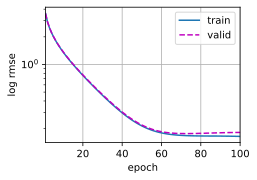

In [88]:
k, num_epochs, lr, weight_decay, batch_size = 20, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [89]:
# 确定超参数后，重新训练整个过程
# 没有划分验证集，直接将所有的训练数据传进去训练
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集
    with torch.no_grad():
        preds = net(test_features).detach().numpy().flatten()
    # 将其重新格式化以导出到Kaggle, 第一列是id，第二列是预测结果
    # 创建Series时，preds必须是一维数据！！！
    test_data['SalePrice'] = pd.Series(preds)  # 没有SalePrice列会自动创建！！！
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162570


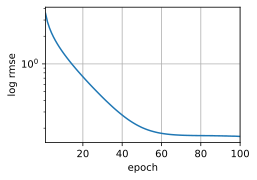

In [90]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)